In [99]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from properties.data.database import DatabaseContext
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor

First of all we clean the data removing any columns that are not valuable:

In [148]:
db = DatabaseContext('properties')
df = db.as_df()
# df = df[(df['stories'] < 7) & (df['garage_spaces'] < 7)]
df['market_value'].replace('', np.nan, inplace=True)
df.dropna(subset=['market_value'], inplace=True)
df['market_value'] = df['market_value'].astype(float)
df = df.drop(columns=['sale_date', 'latitude', 'longitude', 'total_area', 'market_value'])
# df = df.drop(columns = ['total_livable_area','museum', 'gas_station', 'coffee_shop', 'stadium',
#        'food', 'bar', 'gym', 'bridge', 'garden', 'park', 'river', 'city_hall',
#        'police_station', 'hospital', 'elementary_school', 'church', 'bank',
#        'supermarket', 'pharmacy', 'bus_stop', 'metro_station', 'train_station',
#        'university', 'laundromat'])

Now we normalize our distance data

In [149]:
mms = MinMaxScaler()
df[['museum', 'gas_station', 'coffee_shop', 'stadium',
       'food', 'bar', 'gym', 'bridge', 'garden', 'park', 'river', 'city_hall',
       'police_station', 'hospital', 'elementary_school', 'church', 'bank',
       'supermarket', 'pharmacy', 'bus_stop', 'metro_station', 'train_station',
       'university', 'laundromat']] = mms.fit_transform(df[['museum', 'gas_station', 'coffee_shop', 'stadium',
       'food', 'bar', 'gym', 'bridge', 'garden', 'park', 'river', 'city_hall',
       'police_station', 'hospital', 'elementary_school', 'church', 'bank',
       'supermarket', 'pharmacy', 'bus_stop', 'metro_station', 'train_station',
       'university', 'laundromat']])

And our final data becomes

In [150]:
# Our data
y = df['sale_price']
X1 = df

## One Hot

In [151]:
def one_hot(df, columns):
    for column in columns:
        oh = pd.get_dummies(df[column], prefix=column)
        df = df.drop(column, axis=1)
        df = pd.concat([df, oh], axis=1)
    return df

In [174]:
X = one_hot(X1, ['bedrooms', 'bathrooms', 'stories', 'fireplaces', 'garage_spaces'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
y_train.describe()
y_test.describe()



count    1.607000e+03
mean     3.224300e+05
std      2.678921e+05
min      2.421700e+04
25%      1.600000e+05
50%      2.600000e+05
75%      3.987500e+05
max      3.100000e+06
Name: sale_price, dtype: float64

## Filter data to price range 80,000 ~ 800,000

In [175]:
X_train = X_train[X_train['sale_price'] <= 800000][X_train['sale_price'] >= 80000]
y_train = y_train[y_train <= 800000][y_train >= 80000]
X_train = X_train.drop(columns=['sale_price'])


/Users/chih/Documents/upenn/cis519/cis519/Project/real-estate-ml/.env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


## Dive test data to three price range groups

In [176]:
percent25Y_test = y_test[y_test <= 164787][y_test >= 80000]
percent50Y_test = y_test[y_test > 164787][y_test <= 262000]
percent75Y_test = y_test[y_test > 262000][y_test <= 800000]

percent25X_test = (X_test[X_test['sale_price'] <= 164787][X_test['sale_price'] >= 80000]).drop(columns=['sale_price'])
percent50X_test = X_test[X_test['sale_price'] <= 262000][X_test['sale_price'] > 164787].drop(columns=['sale_price'])
percent75X_test = X_test[X_test['sale_price'] > 262000][X_test['sale_price'] <= 800000].drop(columns=['sale_price'])
X_test.drop(columns=['sale_price'])

/Users/chih/Documents/upenn/cis519/cis519/Project/real-estate-ml/.env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/chih/Documents/upenn/cis519/cis519/Project/real-estate-ml/.env/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/chih/Documents/upenn/cis519/cis519/Project/real-estate-ml/.env/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


## Accuray function

In [ ]:
def accuracy(y_true, y_pred, tolerance=0.3):
    score = 0
    for actual, pred in zip(y_true, y_pred):
        if (1 - tolerance) * actual < pred < (1 + tolerance) * actual:
            score += 1
    return score / len(y_true)

## Running SVR

In [8]:
clf = SVR(gamma='scale', degree=5, C=1, epsilon=0.2)
clf.fit(X_train, y_train)

SVR(C=1, cache_size=200, coef0=0.0, degree=5, epsilon=0.2, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [9]:
y_pred = clf.predict(X_test)

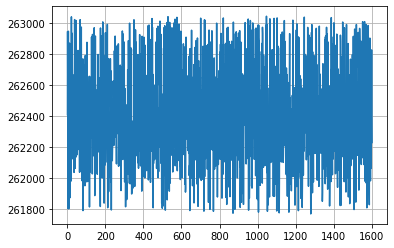

In [10]:
fig, ax = plt.subplots()
ax.plot(y_pred)

ax.grid()

plt.show()

In [11]:
mean_squared_error(y_pred, y_test)

60798259331.66813

## Running Linear Regression

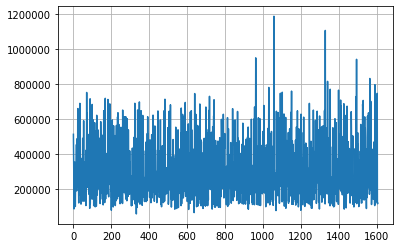

In [155]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test.drop(columns=['sale_price']))
fig, ax = plt.subplots()

ax.plot(y_pred)
ax.grid()
plt.show()

In [156]:
mean_squared_error(y_pred, y_test)

32891577673.96583

In [172]:
accuracy(y_pred, y_test, 0.3)

0.7205973864343497

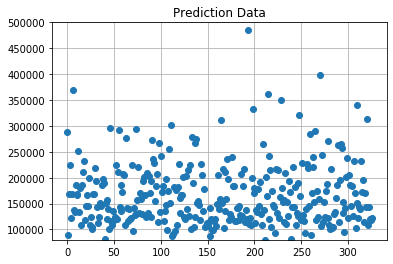

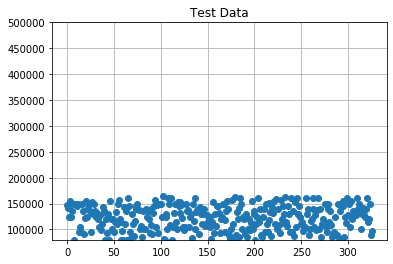

5132372587.858661

In [157]:
#25 predict

percent25Y_pred = reg.predict(percent25X_test)
fig, ax = plt.subplots()

ax.plot(percent25Y_pred, 'o')
ax.grid()
plt.title('Prediction Data')
plt.ylim(80000, 500000)
plt.show()

fig1, ax1 = plt.subplots()

y_test25 = []
for e in percent25Y_test.index:
    y_test25.append(percent25Y_test[e])

ax1.plot(y_test25, 'o')
ax1.grid()
plt.title('Test Data')
plt.ylim(80000, 500000)
plt.show()
mean_squared_error(percent25Y_pred, percent25Y_test)


In [158]:
accuracy(y_test25, percent25Y_pred, 0.6)

0.7484662576687117

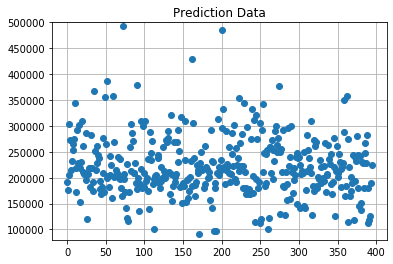

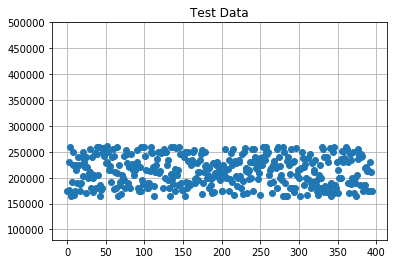

3461920896.433731

In [159]:
#50 predict

percent50Y_pred = reg.predict(percent50X_test)
fig, ax = plt.subplots()

ax.plot(percent50Y_pred, 'o')
ax.grid()
plt.title('Prediction Data')
plt.ylim(80000, 500000)
plt.show()

fig1, ax1 = plt.subplots()

y_test50 = []
for e in percent50Y_test.index:
    y_test50.append(percent50Y_test[e])

ax1.plot(y_test50, 'o')
ax1.grid()
plt.title('Test Data')
plt.ylim(80000, 500000)
plt.show()
mean_squared_error(percent50Y_pred, percent50Y_test)



In [161]:
accuracy(y_test50, percent50Y_pred, 0.3)

0.7670886075949367

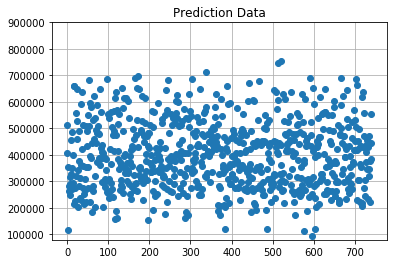

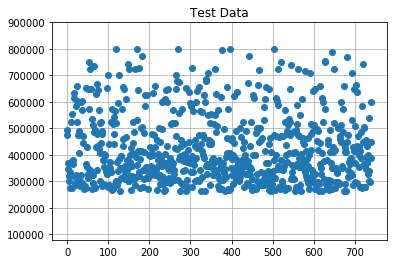

6648377841.319142

In [162]:
#75 predict

percent75Y_pred = reg.predict(percent75X_test)
fig, ax = plt.subplots()

ax.plot(percent75Y_pred, 'o')
ax.grid()
plt.title('Prediction Data')
plt.ylim(80000, 900000)
plt.show()

fig1, ax1 = plt.subplots()

y_test75 = []
for e in percent75Y_test.index:
    y_test75.append(percent75Y_test[e])

ax1.plot(y_test75, 'o')
ax1.grid()
plt.title('Test Data')
plt.ylim(80000, 900000)
plt.show()
mean_squared_error(percent75Y_pred, percent75Y_test)

In [163]:
accuracy(y_test75, percent75Y_pred, 0.2)

0.7516869095816464

## MLP Network

In [165]:
est = MLPRegressor(activation='relu', max_iter=5000)
est.fit(X_train, y_train)

y_pred = est.predict(X_test)

ValueError: shapes (1607,67) and (66,100) not aligned: 67 (dim 1) != 66 (dim 0)

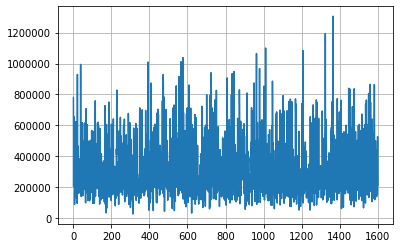

In [231]:
fig, ax = plt.subplots()

ax.plot(y_pred)
ax.grid()
plt.show()

In [180]:
mean_squared_error(y_pred, y_test)

34533030372.994385

## Regression Tree

In [179]:
ext = ExtraTreesRegressor(n_estimators=10, random_state=0, criterion='mse')
ext.fit(X_train, y_train)
y_pred = est.predict(X_test)


5552    349900.0
3422    238000.0
6214    450000.0
3501    298000.0
5023    250000.0
          ...   
5191    352000.0
5226    335000.0
5390    350000.0
7603    650000.0
7270     88900.0
Name: sale_price, Length: 5853, dtype: float64

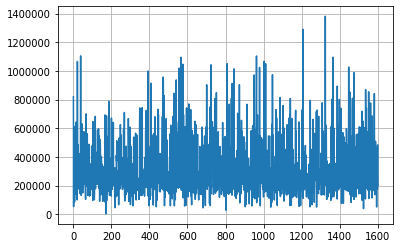

In [143]:
fig, ax = plt.subplots()

ax.plot(y_pred)
ax.grid()
plt.show()

In [211]:
mean_squared_error(y_pred, y_test)

34905812672.60081